In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder 
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import time
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense


In [5]:
# Cargamos los datos
data =  pd.read_csv('TERREMOTOS/Earthquake_train.csv')
test =  pd.read_csv('TERREMOTOS/Earthquake_test.csv')

data.set_index('building_id',inplace=True)
test.set_index('building_id',inplace=True)

X = data.copy().drop('damage_grade',axis=1)
y= data['damage_grade']
print(f'Data shape = {data.shape}')
print(f'Test shape = {test.shape}')

Data shape = (156360, 39)
Test shape = (104241, 38)


# MACHINE LEARNING

In [94]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

print(f'Train shape = {X_train.shape,y_train.shape}')
print(f'Test shape = {X_test.shape,y_test.shape}')

Train shape = ((125088, 38), (125088,))
Test shape = ((31272, 38), (31272,))


## BASELINE - RANDOM FOREST

In [81]:
# Creamos un modelo base para empezar, en este caso un randomforest sin ningún parámetro
baseline_forest = RandomForestClassifier(random_state=42)


In [82]:
# transformamos los datos del train y test ya que presentan variables categóricas, aunque esto aumenta la dimension de las variables creando más columnas 
dummy_X_train = pd.get_dummies(X_train)
dummy_X_test = pd.get_dummies(X_test)



In [95]:
# Creamos una serie de variables para que nos muestre en detalle tanto el tiempo de entrenamiento de train y test, como 
start_time = time.time()
baseline = baseline_forest.fit(dummy_X_train, y_train)
baseline_time_fit = time.time() - start_time

#Predictions -  Tree
start_time = time.time()
pred = baseline.predict(dummy_X_test)
baseline_time_pred = time.time() - start_time
print("Baseline - Random Forest")
print("Fit Time: {} seconds".format(baseline_time_fit))
print("Prediction Time: {} seconds".format(baseline_time_pred))
print("Training Score: {}".format(baseline.score(dummy_X_train, y_train)))
print("Test Score: {}".format(baseline.score(dummy_X_test, y_test)))



Baseline - Random Forest
Fit Time: 29.617804765701294 seconds
Prediction Time: 1.7560346126556396 seconds
Training Score: 0.9911582246098747
Test Score: 0.7013622409823485


In [97]:
f1_micro_baseline = cross_val_score(baseline,dummy_X_train, y_train, scoring='f1_micro',cv=7)
f1_micro_baseline = f1_micro_baseline.mean()
print(f'Media F1 con 7 pliegues = {f1_micro_baseline:.2%}')


Media F1 con 7 pliegues = 70.46%


Obtenemos una puntuación en training de 0.99, parece que se ajusta mucho al train, y presenta una puntuación en test de 0.70, no es mala puntuación pero difiere bastante del train. Hay que intentar subir test, y que el modelo no se ajuste tanto al train. 

En la validación cruzada obtenemos una puntuación de 70.46%, semejante a la puntuación del test.


A continuación mostramos la importancia de variables que le da este modelo de Random forest:

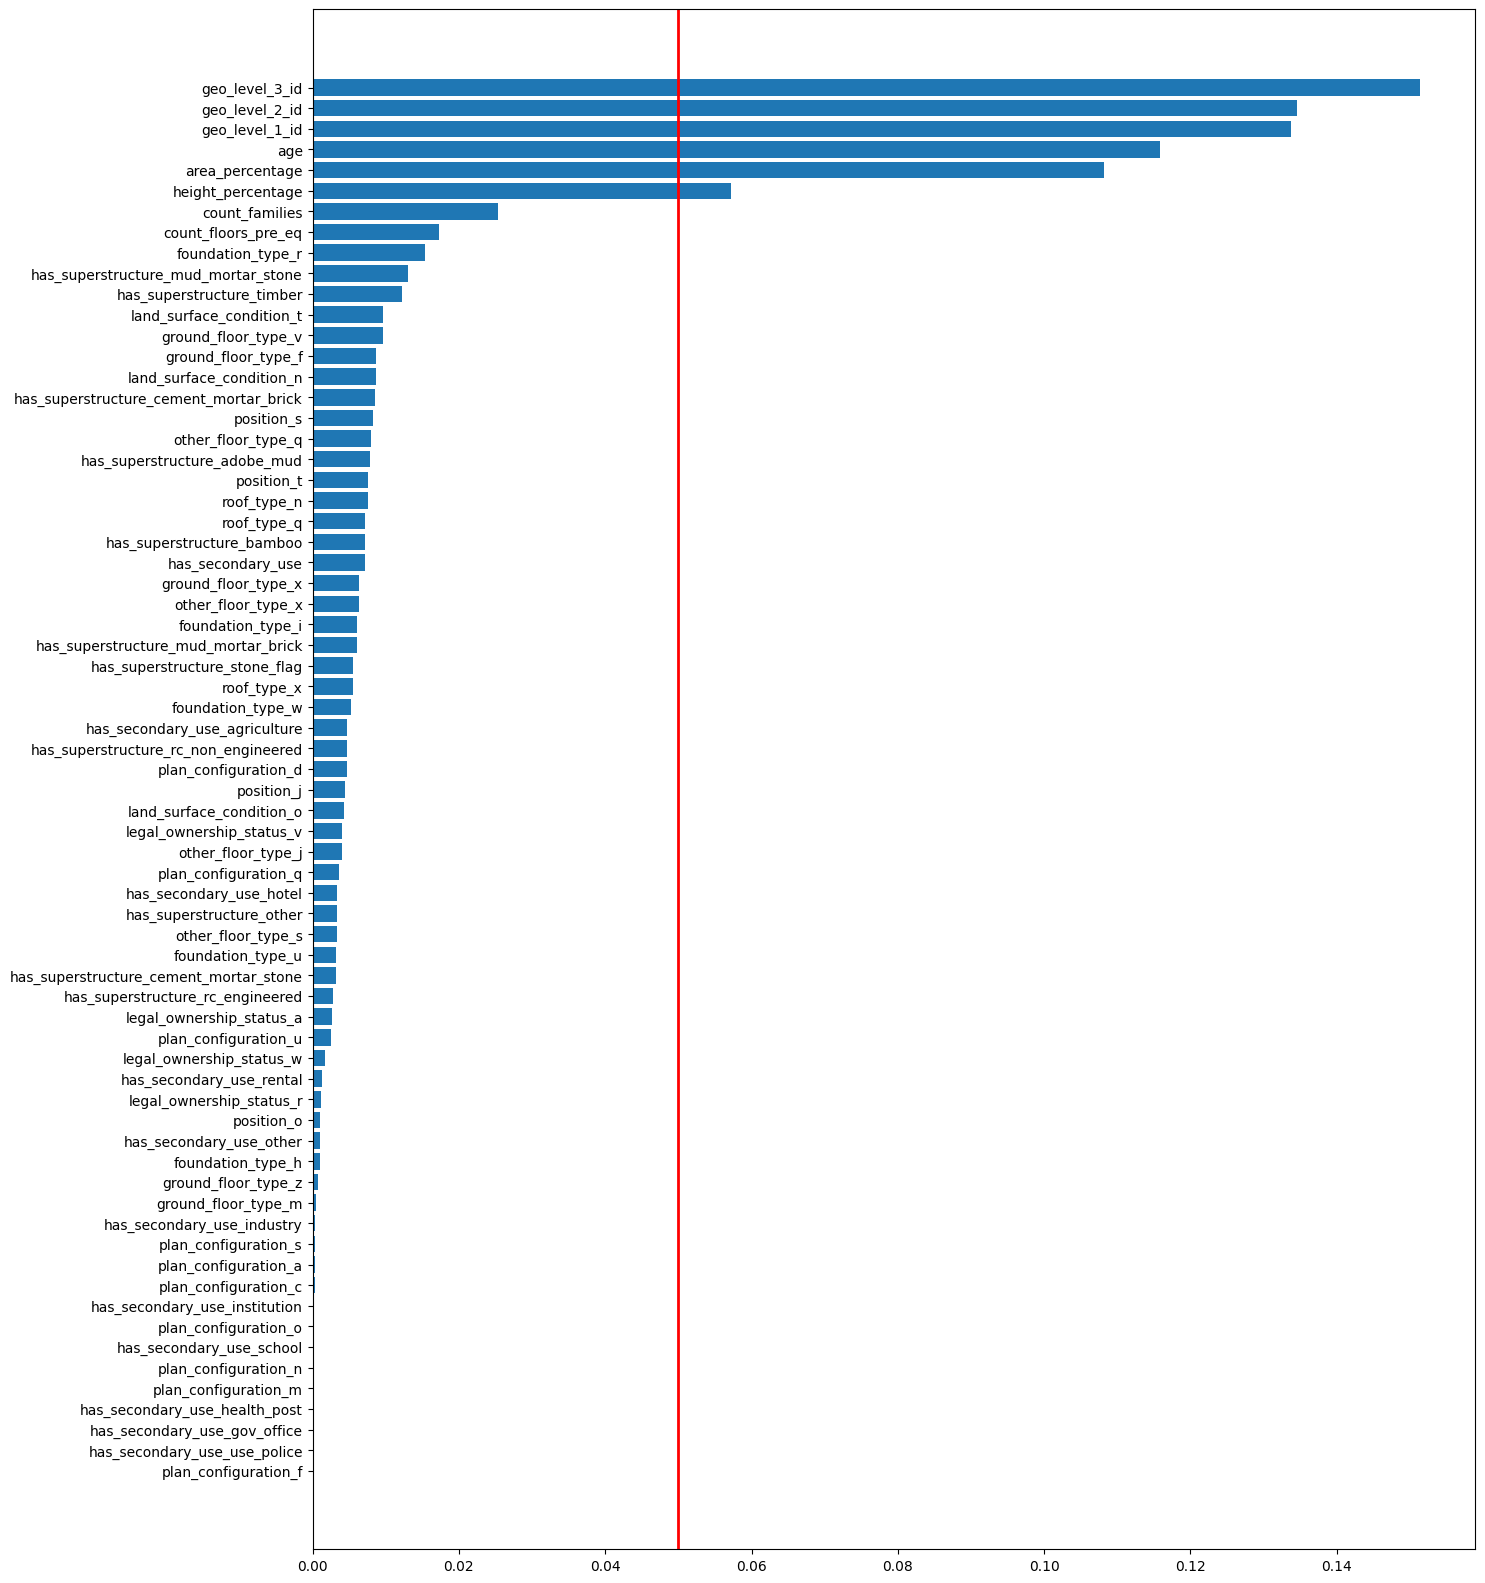

In [ ]:
# Sacamos las columnas que considera más importante
feat_importance = pd.DataFrame(baseline_forest.feature_importances_, 
                               columns=['Importance'], index=dummy_X_train.columns)
feat_importance_sorted = feat_importance.sort_values(by='Importance', ascending=True)
fig, ax = plt.subplots(figsize=(15,20))               
ax.axvline(.05, color='red', linewidth=2)      
ax.barh(feat_importance_sorted.index, feat_importance_sorted.Importance);

El modelo nos muestra las variables que considera más importante, donde se fija más, y nos muestra que son las 3 variables de geolocalización, el año, la altura y el número de familias.

Salvo la última variable, coincido con lo que me muestra, considero importante para predecir el daño esas variables, pero el conteo de familias no es significativo para el nivel de daño de un edificio. Sin embargo parece ser que no se fija mucho en ninguna variable sobre el tipo de construcción.

In [131]:
test_d = test.reset_index()

In [137]:
# Guardamos la predicción en una variable junto el id del edificio
submission = pd.DataFrame({'building_id':test_d.building_id,
                'damage_grade':pred})

submission.to_csv('submission.csv',index=False)                

Este modelo, en la competición de kaggle obtuvo una puntuación de = *0.70917*, casi lo mismo que en validación cruzada y en test.

Comencemos a limpiar variables para tener unos datos más ligeros, además de evitar que el modelo se fije mucho en variables que no son significativas para predecir el nivel de daño, como el caso anterior, que le estaba dando bastante importancia al número de familias.



In [138]:
# Eliminamos estas variables tanto del conjunto de prueba como el test
data.drop(['count_floors_pre_eq','land_surface_condition', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration','legal_ownership_status', 'count_families','damage_grade'],axis=1,inplace=True)

test.drop(['count_floors_pre_eq','land_surface_condition', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration','legal_ownership_status', 'count_families'],axis=1,inplace=True)

In [139]:
# Eliminamos de ambos datos todas aquellas variable que comienzan por 'has_secondary'
for col in data:
    if col.startswith('has_secondary'):
        data.drop(col,axis=1,inplace=True)
    if col == object:
        data.drop(col,axis=1,inplace=True)

for col in test:
    if col.startswith('has_secondary'):
        test.drop(col,axis=1,inplace=True)
    if col == object:
        test.drop(col,axis=1,inplace=True)

Por lo tanto, considero que son importantes para poder predecir el tipo de daño en un edificio tras un terremoto, los niveles de geolocalización, como mostraba el modelo, el año y la altura del edificio, así como sus huellas en area y altura y todas las superestructuras correspondientes al material

In [140]:
print(f'data Shape  = {data.shape}')
data.columns

data Shape  = (156360, 18)


Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'age',
       'area_percentage', 'height_percentage', 'foundation_type',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other'],
      dtype='object')

Vemos que tenemos una única variable categórica, foundation_type, que se refiere al tipo de cimientos que presenta la estructura con 5 categorías

In [ ]:
data.info()
print('\n')
print(f' Categorias de foundation type = {data.foundation_type.unique()}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156360 entries, 903419 to 738067
Data columns (total 18 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          156360 non-null  int64 
 1   geo_level_2_id                          156360 non-null  int64 
 2   geo_level_3_id                          156360 non-null  int64 
 3   age                                     156360 non-null  int64 
 4   area_percentage                         156360 non-null  int64 
 5   height_percentage                       156360 non-null  int64 
 6   foundation_type                         156360 non-null  object
 7   has_superstructure_adobe_mud            156360 non-null  int64 
 8   has_superstructure_mud_mortar_stone     156360 non-null  int64 
 9   has_superstructure_stone_flag           156360 non-null  int64 
 10  has_superstructure_cement_mortar_stone  156360 non-

Le aplicamos una transformación a esa variable para volverla numérica, en este caso binario, ya que no queremos darle numeros a cada categoría para no dar mayor importancia a unas y a otras.

In [141]:
data_onehot = pd.get_dummies(data, columns=['foundation_type'])
test_onehot = pd.get_dummies(test, columns=['foundation_type'])

print(f'data Train shape = {data_onehot.shape}')
print(f'data Test shape = {test_onehot.shape}')


data Train shape = (156360, 22)
data Test shape = (104241, 22)


In [142]:
X_train,X_test,y_train,y_test = train_test_split(data_onehot,y, test_size = 0.2, random_state = 42)

print(f'Train shape = {X_train.shape,y_train.shape}')
print(f'Test shape = {X_test.shape,y_test.shape}')

Train shape = ((125088, 22), (125088,))
Test shape = ((31272, 22), (31272,))


Crearemos un grid search para ver con que parámetros empezar

In [ ]:
# parámetros para randomforest
param_grid_rforest = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10]}
# parámetros para regresión logística
param_grid_logreg = {
    'C': [0.1,0.5, 1,],
    'multi_class': ['ovr', 'multinomial']
}

# Creamos un objeto de GridSearchCV para cada modelo
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rforest, cv=5, verbose=3,n_jobs=-1,scoring="f1_micro")
# grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, verbose=3,n_jobs=-1)
grid_logreg = GridSearchCV(LogisticRegression(), param_grid_logreg, cv=5, verbose=3,n_jobs=-1,scoring="f1_micro")


grids = {"gs_rand_forest":grid_rf,
        # "gs_svm":grid_svm,
         "gs_logreg":grid_logreg
         }
# Entrenamos y evaluamos cada modelo
for nombre, grid_search in grids.items():
    grid_search.fit(X_train,y_train)

# Imprimimos los resultados
print(f"Mejores parámetros para random forest: {grid_rf.best_params_}")
# print(f"Mejores parámetros para SVM: {grid_svm.best_params_}")
print(f"Mejores parámetros para regresión logística: {grid_logreg.best_params_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros para random forest: {'max_depth': None, 'n_estimators': 100}
Mejores parámetros para regresión logística: {'C': 0.5, 'multi_class': 'ovr'}


Vemos que nos sugiere randomforest y los parámetros para el mismo

In [ ]:
best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
0,gs_rand_forest,0.701858
1,gs_logreg,0.567824


## RANDOM FOREST

Random forest es un modelo de machine learning que en esencia es una agrupacion de árboles de decisión,lo que lo hace bueno para manejar un gran número de datos, y es versátil tanto para clasificación como regresión, además responde bien al overfitting, sin ajustarse demasiado al train.

In [ ]:
# Estandarizamos los datos
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
#Random Forest
rf1 = RandomForestClassifier(max_features = None,
                            n_estimators= 100)
                            
start_time = time.time()
model = rf1.fit(X_train_sc, y_train)
rf_time_fit = time.time() - start_time

start_time = time.time()
model.predict(X_test_sc)
rf1_time_pred = time.time() - start_time
print("Random Forest")
print("Fit Time: {} seconds".format(rf_time_fit))
print("Prediction Time: {} seconds".format(rf1_time_pred))
print("Training Score: {}".format(rf1.score(X_train_sc, y_train)))
print("Test Score: {}".format(rf1.score(X_test_sc, y_test)))

Random Forest
Fit Time: 52.52456593513489 seconds
Prediction Time: 1.0974392890930176 seconds
Training Score: 0.97544128933231
Test Score: 0.7045599897672039


Creamos una confusionMatrix para poder ver mejor como predice nuestro modelo

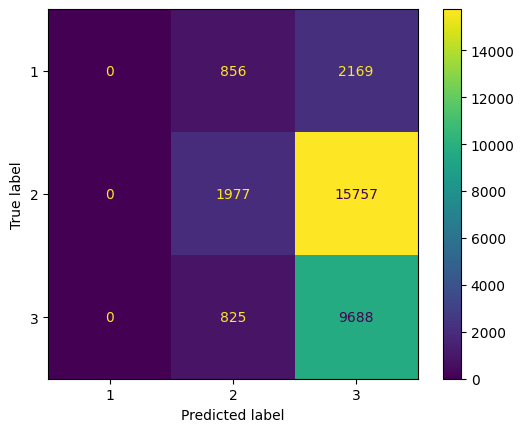

In [ ]:
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix
plot_confusion_matrix(rf1, X_test, y_test)


In [ ]:
cmrf1 = confusion_matrix(y_test, y_pred)
low_damage = cmrf1[0][0] / (cmrf1[0][0] + cmrf1[0][1] + cmrf1[0][2])
medium_damage = cmrf1[1][1] / (cmrf1[1][0] + cmrf1[1][1] + cmrf1[1][2])
complete_destruction = cmrf1[2][2] / (cmrf1[2][0] + cmrf1[2][1] + cmrf1[2][2])
print(f'The model correctly predicts {round(low_damage*100, 2)}% of low damage.')
print(f'The model correctly predicts {round(medium_damage*100, 2)}% of medium damage.')
print(f'The model correctly predicts {round(complete_destruction*100, 2)}% of complete destruction.')

The model correctly predicts 0.0% of low damage.
The model correctly predicts 11.15% of medium damage.
The model correctly predicts 92.15% of complete destruction.


El modelo nos predice muy mal el nivel 1 de daño, se esperaba un nivel menor en esta categoría pero el modelo no es correcto, porque no predice nada en el nivel 1 y como veremos a continuación, presenta gran overfitting del train.

In [98]:
y.shape

(156360,)

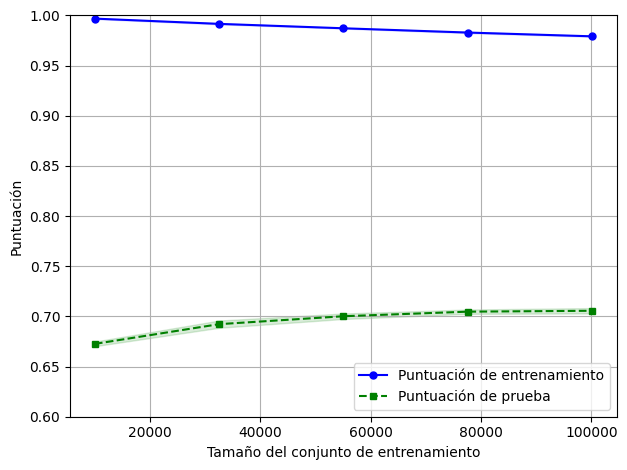

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Crear modelo
model = rf1

# Crear conjunto de entrenamiento y prueba
X = X_train_sc
y = y_train

# Calcular puntuaciones de entrenamiento y prueba para diferentes tamaños de conjunto de entrenamiento
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# Calcular media y desviación típica de las puntuaciones
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear gráfico
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Puntuación de entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Puntuación de prueba')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Puntuación')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.tight_layout()
plt.show()



Creamos otro RandomForest pero esta vez modificamos más parámetros

In [ ]:
rf2 = RandomForestClassifier(max_features = None,
                            max_depth = 45,
                            min_samples_split = 3,
                            min_samples_leaf = 30,
                            random_state=42)
start_time = time.time()
model = rf2.fit(X_train_sc, y_train)
rf_time_fit = time.time() - start_time

start_time = time.time()
model.predict(X_test_sc)
rf_time_pred = time.time() - start_time
print("Random Forest")
print("Fit Time: {} seconds".format(rf_time_fit))
print("Prediction Time: {} seconds".format(rf_time_pred))
print("Training Score: {}".format(rf2.score(X_train_sc, y_train)))
print("Test Score: {}".format(rf2.score(X_test_sc, y_test)))

Random Forest
Fit Time: 40.62601184844971 seconds
Prediction Time: 0.6060791015625 seconds
Training Score: 0.7448836019442313
Test Score: 0.7185341519570223


In [ ]:
y_pred_rf2 = model.predict(X_test_sc)

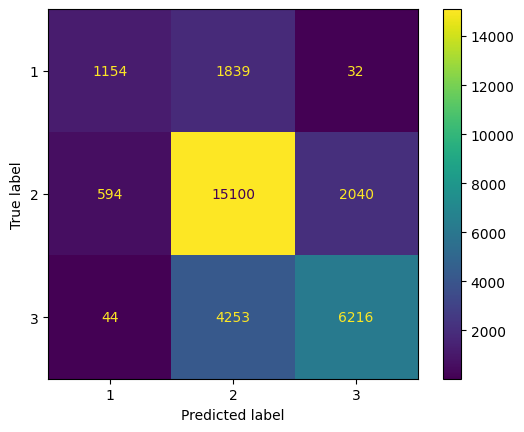

In [ ]:
plot_confusion_matrix(rf2, X_test_sc, y_test)


In [ ]:
cmrf2 = confusion_matrix(y_test, y_pred_rf2)
low_damage = cmrf2[0][0] / (cmrf2[0][0] + cmrf2[0][1] + cmrf2[0][2])
medium_damage = cmrf2[1][1] / (cmrf2[1][0] + cmrf2[1][1] + cmrf2[1][2])
complete_destruction = cmrf2[2][2] / (cmrf2[2][0] + cmrf2[2][1] + cmrf2[2][2])
print(f'El modelo predice correctamente el {round(low_damage*100, 2)}% de daño bajo.')
print(f'El modelo predice correctamente el {round(medium_damage*100, 2)}% de daño medio.')
print(f'El modelo predice correctamente el {round(complete_destruction*100, 2)}% de los destruidos.')

El modelo predice correctamente el 38.15% de daño bajo.
El modelo predice correctamente el 85.15% de daño medio.
El modelo predice correctamente el 59.13% de los destruidos.


Aquí vemos que nuestro modelo ha mejorado en comparación con el anterior, tenemos un 38% de acierto en el nivel 1

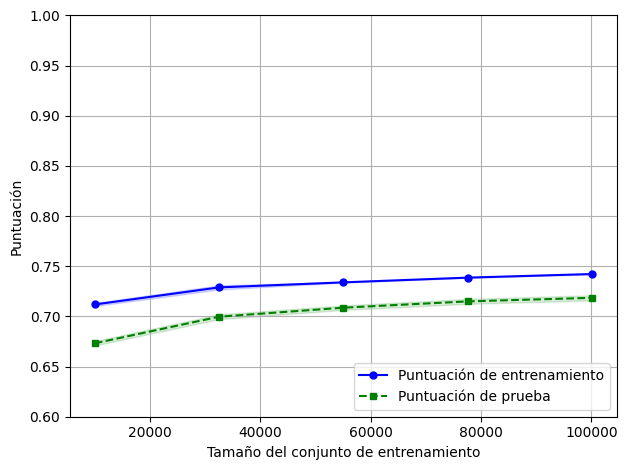

In [ ]:
model = rf2
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# Calcular media y desviación típica de las puntuaciones
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear gráfico
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Puntuación de entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Puntuación de prueba')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Puntuación')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.tight_layout()
plt.show()


Observamos que el modelo ha mejorado bastante respecto al anterior, si recordamos, la puntuación de train no bajaba del 0.98, muy lejano a la puntuación con respecto al test.

Es cierto que la puntuación del test no ha aumentado de manera muy significativa, pero sí que ha mejorado sus predicciones en el nivel 1 de daño.

In [ ]:
# Guardamos la predicción en una variable junto el id del edificio
submission_rf2 = pd.DataFrame({'building_id':test.building_id,
                'damage_grade':y_pred_rf2})

submission_rf2.to_csv('submission_rf2.csv',index=False)                

Este modelo ha dado una puntuación de *0.71611* en Kaggle

## XGBoost (eXtreme Gradient Boosting) 

Es un algoritmo de aprendizaje automático de árboles de decisión utiliza una técnica llamada boosting, que consiste en entrenar varios modelos secuencialmente, cada uno de ellos tratando de corregir los errores del modelo anterior. Esto permite que XGBoost obtenga un rendimiento muy alto en muchos problemas de clasificación y regresión. Por lo tanto, es como un RandomForest pero más potente por ese boosting que implanta.


Veamos cómo se comporta el modelo, creamos un gridsearch para ver qué parametros nos da

In [ ]:
# Tenemos que hacerle un labelencoder al target, debido a que va de 1 a 3, sin 0, y XGB no entiende que se empiece por el 1. 
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
print(f'Mínimo antes de LabelEncoder = {min(y_train)}')
print(f'Mínimo después de LabelEncoder = {min(y_train_encoded)}')

# Hacemos lo mismo con el test
y_test_encoded = le.fit_transform(y_test)


Mínimo antes de LabelEncoder = 1
Mínimo después de LabelEncoder = 0


In [ ]:
# Especifica el modelo que deseas utilizar
model = XGBClassifier()

# Agrega más valores para los hiperparámetros
param_grid = {
    'n_estimators': [400,600,800,1000],
    'max_depth': [25, 35, 55, 75],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 5, 7],
    'gamma': [0, 1, 3],
    'subsample': [0, 0.5, 1]
}

# Utiliza una técnica de optimización de hiperparámetros más avanzada (búsqueda aleatoria en este caso)
from sklearn.model_selection import RandomizedSearchCV

# Especifica una métrica de evaluación adicional (accuracy en este caso)
scoring = ['f1_micro', 'accuracy']

# Realiza la búsqueda aleatoria
random_search = RandomizedSearchCV(model, param_grid, cv=5, n_iter=10, scoring=scoring, refit='f1_micro', return_train_score=True, n_jobs=-1,verbose = 3)

# Normaliza o estandariza el conjunto de datos de entrenamiento antes de utilizarlo para la búsqueda
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Ajusta el modelo utilizando la búsqueda aleatoria
random_search.fit(X_train_scaled, y_train_encoded)


results = pd.DataFrame.from_dict(random_search.cv_results_)
print(f'Best score: {random_search.best_score_:.4f}')
print(f'Best parameters: {random_search.best_params_}')
results.to_csv('results.csv',index=False)   

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
xgb = XGBClassifier(n_estimators=600, max_depth=10, learning_rate=0.1,random_state=0)
start_time = time.time()
model = xgb.fit(X_train_sc, y_train_encoded)
xgb_time_fit = time.time() - start_time

start_time = time.time()
model.predict(X_test_sc)
xgb_time_pred = time.time() - start_time
print("XGB")
print("Fit Time: {} seconds".format(xgb_time_fit))
print("Prediction Time: {} seconds".format(xgb_time_pred))
print("Training Score: {}".format(model.score(X_train_sc, y_train_encoded)))
print("Test Score: {}".format(model.score(X_test_sc, y_test_encoded)))

XGB
Fit Time: 156.1777687072754 seconds
Prediction Time: 0.9395554065704346 seconds
Training Score: 0.8731373113328217
Test Score: 0.7288948580199539


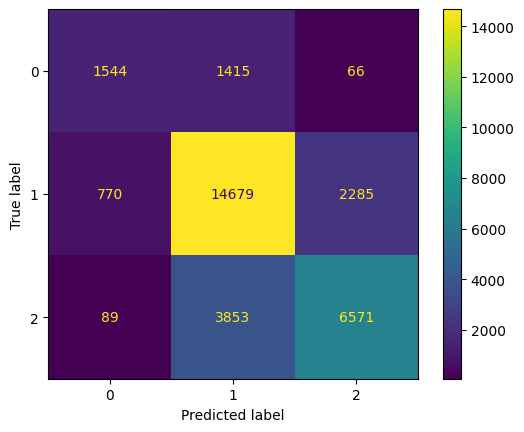

In [112]:
y_pred_xgb= model.predict(X_test_sc)
plot_confusion_matrix(xgb, X_test_sc, y_test_encoded)


In [113]:
xgb1 = confusion_matrix(y_test_encoded, y_pred_xgb)
low_damage = xgb1[0][0] / (xgb1[0][0] + xgb1[0][1] + xgb1[0][2])
medium_damage = xgb1[1][1] / (xgb1[1][0] + xgb1[1][1] + xgb1[1][2])
complete_destruction = xgb1[2][2] / (xgb1[2][0] + xgb1[2][1] + xgb1[2][2])
print(f'El modelo predice correctamente el {round(low_damage*100, 2)}% de daño bajo.')
print(f'El modelo predice correctamente el {round(medium_damage*100, 2)}% de daño medio.')
print(f'El modelo predice correctamente el {round(complete_destruction*100, 2)}% de los destruidos.')

El modelo predice correctamente el 47.93% de daño bajo.
El modelo predice correctamente el 84.23% de daño medio.
El modelo predice correctamente el 60.69% de los destruidos.


Con este modelo hemos aumentado el nivel de predicción de todas las variables.

In [100]:
# Transformamos la y 
y_c = le.fit_transform(y)

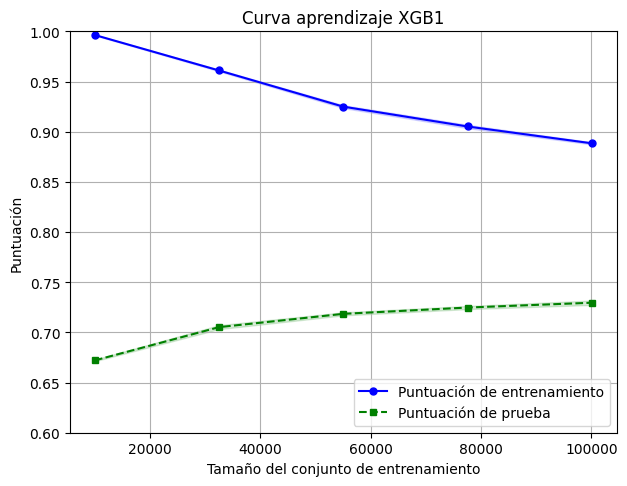

In [ ]:
model = xgb
train_sizes, train_scores, test_scores = learning_curve(model, X, y_c, cv=5)

# Calcular media y desviación típica de las puntuaciones
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear gráfico
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Puntuación de entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Puntuación de prueba')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Puntuación')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.tight_layout()
plt.title('Curva aprendizaje XGB1')
plt.show()

Empieza con cierta ligera de overfitting, pero parece que va rectificando, vemos que el target tambien aumenta

In [ ]:
y_test = le.inverse_transform(y_pred_xgb)

In [ ]:
submission_xgb1 = pd.DataFrame({'building_id':test.building_id,
                'damage_grade':y_test})

submission_xgb1.to_csv('submission_xgb.csv',index=False)                

array([2, 1, 3], dtype=int64)

Ésta submission dio una puntuación de 0.74094 en kaggle

## LightGBM (Light Gradient Boosting Machine)

Es un algoritmo muy parecido a XGB, que predice tanto para problemas de clasificación,como de regresión, y también utiliza boosting, la diferencia es que es más rápido que XGB.


Utilizamos un Gridsearch para ver qué valores nos da cómo mejores parámetros para ahorrarnos tiempo y también para ver entre que valores tenemos que empezar.

In [ ]:
# Definimos los valores para cada parámetro
param_grid = {
    "boosting_type": ["gbdt", "dart", "goss"],
    "num_leaves": [30, 50, 70],
    "max_depth": [5, 10, 15],
    "learning_rate": [0.1, 0.2, 0.3],
    "n_estimators": [100, 200, 300]
}
model = LGBMClassifier()

grid_search = GridSearchCV(model, param_grid, scoring="f1_micro")
grid_search.fit(X_train_sc, y_train_encoded)
print("Mejores parámetros:", grid_search.best_params_)


Mejores parámetros: {'boosting_type': 'gbdt', 'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 300, 'num_leaves': 70}


Probamos los parámetros que nos ha generado

In [114]:
LGBM = LGBMClassifier(boosting_type='gbdt',learning_rate=.2,max_depth=15,n_estimators=300, num_leaves=70,objective='multiclass')
start_time = time.time()
model = LGBM.fit(X_train_sc, y_train_encoded)
LGBM_time_fit = time.time() - start_time

start_time = time.time()
model.predict(X_test_sc)
LGBM_time_pred = time.time() - start_time
print("LGBM")
print("Fit Time: {} seconds".format(LGBM_time_fit))
print("Prediction Time: {} seconds".format(LGBM_time_pred))
print("Training Score: {}".format(model.score(X_train_sc, y_train_encoded)))
print("Test Score: {}".format(model.score(X_test_sc, y_test_encoded)))

LGBM
Fit Time: 7.2684645652771 seconds
Prediction Time: 0.4275200366973877 seconds
Training Score: 0.807367613200307
Test Score: 0.7280634433358916


La puntuación es bastante parecida a la anterior de XGB, y el score de training ha bajado un poco, lo que es bueno ya que no nos interesa una gran diferencia de scores entre train y test, y es preferible que no se ajuste tanto al train.

Aplicamos get dummies al dataset, que en concreto tiene solo una columna categórica como hemos mencionado anteriormente.

In [7]:
import pandas as pd
X_d = pd.get_dummies(X)

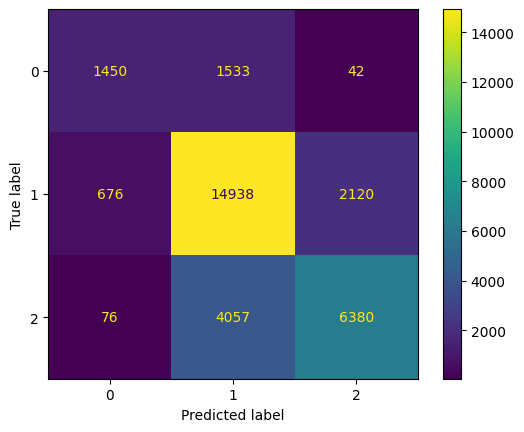

In [115]:
y_pred_lgbm= model.predict(X_test_sc)
plot_confusion_matrix(LGBM, X_test_sc, y_test_encoded)

In [116]:
lgbm = confusion_matrix(y_test_encoded, y_pred_lgbm)
low_damage = lgbm[0][0] / (lgbm[0][0] + lgbm[0][1] + lgbm[0][2])
medium_damage = lgbm[1][1] / (lgbm[1][0] + lgbm[1][1] + lgbm[1][2])
complete_destruction = lgbm[2][2] / (lgbm[2][0] + lgbm[2][1] + lgbm[2][2])
print(f'El modelo predice correctamente el {round(low_damage*100, 2)}% de daño bajo.')
print(f'El modelo predice correctamente el {round(medium_damage*100, 2)}% de daño medio.')
print(f'El modelo predice correctamente el {round(complete_destruction*100, 2)}% de los destruidos.')

El modelo predice correctamente el 47.93% de daño bajo.
El modelo predice correctamente el 84.23% de daño medio.
El modelo predice correctamente el 60.69% de los destruidos.


Observamos que se comporta igual que XGB no hay diferencia entre este modelo y el anterior visto, sigue habiendo tendencia a los falsos positivos.

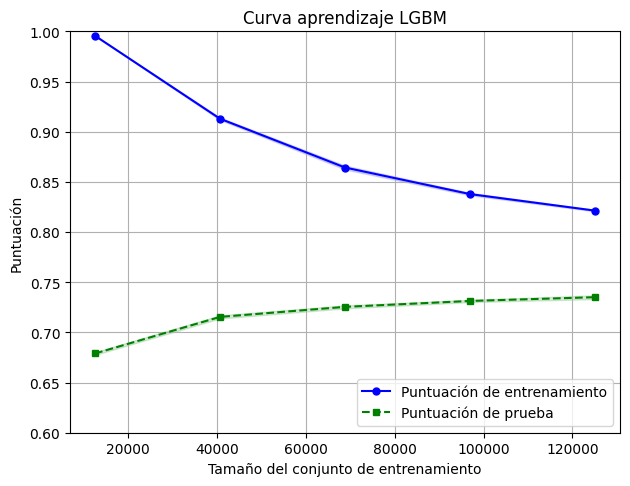

In [120]:
model = LGBM
train_sizes, train_scores, test_scores = learning_curve(model, X_d, y_c, cv=5)

# Calcular media y desviación típica de las puntuaciones
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear gráfico
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Puntuación de entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Puntuación de prueba')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Puntuación')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.tight_layout()
plt.title('Curva aprendizaje LGBM')
plt.show()

En este gráfico observamos cómo a medida que avanza el entrenamiento va rectificando los errores, al igual que aumenta, en menor medida, el score de test, estando más cerca que con XGB.

Modificamos los hiperparámetros para ver como se comporta el modelo, si nos aumenta el score o lo hace peor que el anterior.

In [149]:
# modificamos estos hiperparámetros
LGBM2 = LGBMClassifier(boosting_type='gbdt',learning_rate=.1,n_estimators=850,max_depth = -1,
num_leaves = 75,objective='multiclass')
start_time = time.time()
model = LGBM2.fit(X_train_sc, y_train_encoded)
LGBM2_time_fit = time.time() - start_time

start_time = time.time()
model.predict(X_test_sc)
LGBM2_time_pred = time.time() - start_time
print("LightBMC")
print("Fit Time: {} seconds".format(LGBM2_time_fit))
print("Prediction Time: {} seconds".format(LGBM2_time_pred))
print("Training Score: {}".format(model.score(X_train_sc, y_train_encoded)))
print("Test Score: {}".format(model.score(X_test_sc, y_test_encoded)))

LightBMC
Fit Time: 21.98442578315735 seconds
Prediction Time: 1.4202561378479004 seconds
Training Score: 0.8325019186492709
Test Score: 0.7299501151189562


Nos ha mejorado la métrica un poco más, vamos a observar cómo se comporta con la matriz de confusión

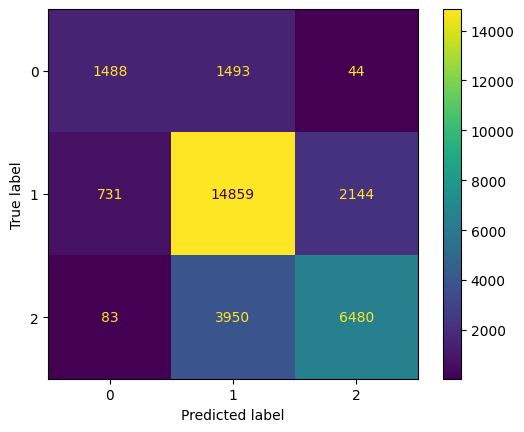

In [150]:
y_pred_lgbm2= model.predict(X_test_sc)
plot_confusion_matrix(LGBM2, X_test_sc, y_test_encoded)

In [152]:
lgbm2 = confusion_matrix(y_test_encoded, y_pred_lgbm2)
low_damage = lgbm2[0][0] / (lgbm2[0][0] + lgbm2[0][1] + lgbm2[0][2])
medium_damage = lgbm2[1][1] / (lgbm2[1][0] + lgbm2[1][1] + lgbm2[1][2])
complete_destruction = lgbm2[2][2] / (lgbm2[2][0] + lgbm2[2][1] + lgbm2[2][2])
print(f'El modelo predice correctamente el {round(low_damage*100, 2)}% de daño bajo.')
print(f'El modelo predice correctamente el {round(medium_damage*100, 2)}% de daño medio.')
print(f'El modelo predice correctamente el {round(complete_destruction*100, 2)}% de los destruidos.')

El modelo predice correctamente el 49.19% de daño bajo.
El modelo predice correctamente el 83.79% de daño medio.
El modelo predice correctamente el 61.64% de los destruidos.


Ha aumentado un poco los porcentajes de acierto de las variables con este modelo, lo interesante es que ha suavizado los valores, ya que han aumentado los niveles 1 y 3, y ha disminuido el de nivel 2, donde se concentraba la mayor puntuación, mostrando bastante desigualdad.

In [171]:
test1 = sc.fit_transform(test_onehot)

In [172]:
model = LGBM2             
y_hat_lgb2  =model.predict(test1)
y_hat_lgb2 = y_hat_lgb2 +1
submission_lgb2 = pd.DataFrame({'building_id':test_d.building_id,
                'damage_grade':y_hat_lgb2})
submission_lgb2.to_csv('submission_lgb2.csv',index=False) 


Este modelo dio una puntuación de *0.74094* en Kaggle

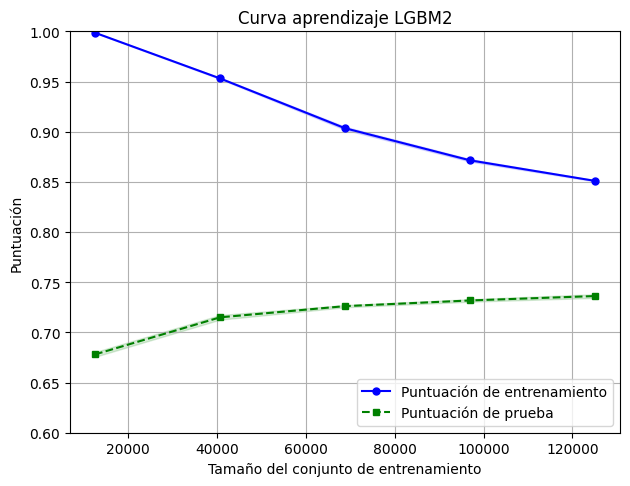

In [175]:
model = LGBM2
train_sizes, train_scores, test_scores = learning_curve(model, X_d, y_c, cv=5)

# Calcular media y desviación típica de las puntuaciones
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear gráfico
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Puntuación de entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Puntuación de prueba')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Puntuación')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.tight_layout()
plt.title('Curva aprendizaje LGBM2')
plt.show()

Observamos la misma tendencia que la anterior, parece que va rectificando bastante bien los errores, por lo que, éste modelo en concreto, considero que sería el mejor predictor, ya que lo que me parece más interesante de él, para poder descartar el XGB que hemos visto que tiene la misma puntuación, es que XGB su curva de aprendizaje muestra que aprende o corrige menos los errores que éste, ya que se ve que decrece bastante rápido y aumenta el test, bastante menos, pero aumenta un poco, por lo que prefiero un train score más suavizado pero que esté mejor equilibrado, en este caso en distancias o métrica.

## REDES NEURONALES

Como una forma de 'Bonus', probaremos a crear una red neuronal simple, para ver cómo se comportaría prediciendo.


Para ello prepararemos los datos para poder realizarlo

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
# aplicamos PCA a todo el dataset ya que nos reduce la dimensionalidad, 
# que pare redes neuronales es bastante importante porque es un calculo mas complejo
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_d)
y_le = le.fit_transform(y)



# Ahora utilizaremos un one hot encoding al target
y_categorical = to_categorical(y_le, num_classes=3)
y_categorical

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [18]:
import tensorflow as tf
import tensorflow_addons as tfa


# Definimos nuestro modelo
model = Sequential()

# Y le añadimos layers
model.add(Dense(64, input_dim=X_train_pca.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(3, activation='softmax'))


# Compilamos el modelo con categorical_crossentropy como funciónd de pérdida
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

resultado = model.fit(X_train_pca, y_categorical, epochs=50, batch_size=1000, validation_split=0.2)


Epoch 1/50
126/126 [==============================] - 2s 5ms/step - loss: 14.8493 - accuracy: 0.4472 - val_loss: 6.2877 - val_accuracy: 0.4544
Epoch 2/50
126/126 [==============================] - 0s 3ms/step - loss: 3.5977 - accuracy: 0.4615 - val_loss: 3.9664 - val_accuracy: 0.5436
Epoch 3/50
126/126 [==============================] - 0s 3ms/step - loss: 4.2028 - accuracy: 0.4656 - val_loss: 2.4633 - val_accuracy: 0.3830
Epoch 4/50
126/126 [==============================] - 0s 3ms/step - loss: 3.1749 - accuracy: 0.4737 - val_loss: 4.2163 - val_accuracy: 0.4327
Epoch 5/50
126/126 [==============================] - 0s 3ms/step - loss: 2.7504 - accuracy: 0.4740 - val_loss: 3.2665 - val_accuracy: 0.5644
Epoch 6/50
126/126 [==============================] - 0s 3ms/step - loss: 3.1565 - accuracy: 0.4739 - val_loss: 2.6165 - val_accuracy: 0.5584
Epoch 7/50
126/126 [==============================] - 0s 3ms/step - loss: 3.9150 - accuracy: 0.4708 - val_loss: 8.0020 - val_accuracy: 0.4602
Epoch

In [19]:
resultado = model.fit(X_train_pca, y_categorical, epochs=80, batch_size=64, validation_split=0.2)


Epoch 1/80
1955/1955 [==============================] - 4s 2ms/step - loss: 2.1371 - accuracy: 0.4960 - val_loss: 1.3819 - val_accuracy: 0.4469
Epoch 2/80
1955/1955 [==============================] - 4s 2ms/step - loss: 1.4737 - accuracy: 0.5122 - val_loss: 1.2606 - val_accuracy: 0.4837
Epoch 3/80
1955/1955 [==============================] - 4s 2ms/step - loss: 1.1836 - accuracy: 0.5249 - val_loss: 1.1220 - val_accuracy: 0.5635
Epoch 4/80
1955/1955 [==============================] - 4s 2ms/step - loss: 1.0035 - accuracy: 0.5366 - val_loss: 1.0164 - val_accuracy: 0.5687
Epoch 5/80
1955/1955 [==============================] - 3s 2ms/step - loss: 0.9056 - accuracy: 0.5500 - val_loss: 0.8556 - val_accuracy: 0.5254
Epoch 6/80
1955/1955 [==============================] - 4s 2ms/step - loss: 0.8678 - accuracy: 0.5540 - val_loss: 0.8594 - val_accuracy: 0.5697
Epoch 7/80
1955/1955 [==============================] - 4s 2ms/step - loss: 0.8524 - accuracy: 0.5666 - val_loss: 0.8333 - val_accuracy:

In [230]:
resultado = model.fit(X_train_pca, y_categorical, epochs=800, batch_size=100, validation_split=0.2)


Epoch 1/800
1251/1251 [==============================] - 2s 2ms/step - loss: 0.8433 - accuracy: 0.5690 - val_loss: 0.8497 - val_accuracy: 0.5722
Epoch 2/800
1251/1251 [==============================] - 2s 2ms/step - loss: 0.8229 - accuracy: 0.5771 - val_loss: 0.8195 - val_accuracy: 0.5812
Epoch 3/800
1251/1251 [==============================] - 2s 2ms/step - loss: 0.8180 - accuracy: 0.5806 - val_loss: 0.8341 - val_accuracy: 0.5763
Epoch 4/800
1251/1251 [==============================] - 2s 2ms/step - loss: 0.8150 - accuracy: 0.5825 - val_loss: 0.8170 - val_accuracy: 0.5878
Epoch 5/800
1251/1251 [==============================] - 2s 2ms/step - loss: 0.8150 - accuracy: 0.5827 - val_loss: 0.8114 - val_accuracy: 0.5949
Epoch 6/800
1251/1251 [==============================] - 2s 2ms/step - loss: 0.8094 - accuracy: 0.5890 - val_loss: 0.8091 - val_accuracy: 0.5891
Epoch 7/800
1251/1251 [==============================] - 2s 2ms/step - loss: 0.8114 - accuracy: 0.5885 - val_loss: 0.8144 - val_ac

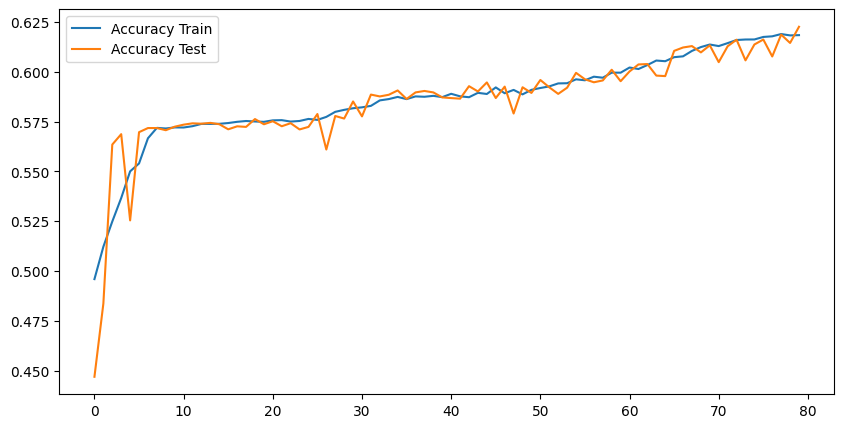

In [20]:
import seaborn as sns
train_f1_micro = resultado.history['accuracy']
val_f1_micro = resultado.history['val_accuracy']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=resultado.epoch, y=train_f1_micro, ax=ax, label='Accuracy Train')
sns.lineplot(x=resultado.epoch, y=val_f1_micro, ax=ax, label='Accuracy Test');

Observamos que el test un poco de ruido, no es suave, por lo que el número de epocas tendremos que disminuirlo, también debemos probar a cambiar el learning rate y aplicar una regularización, como por ejemplo la regularización L2, ya que introduce penalización y puede hacer que la línea sea un poco más suave.